# üöÄ LangGraph Quickstart

## Setup

In [1]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

## Part 1: Build a Basic Chatbot

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [4]:
graph_builder.add_edge(START, "chatbot")

In [5]:
graph_builder.add_edge("chatbot", END)

In [6]:
graph = graph_builder.compile()

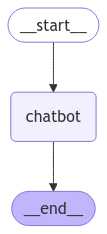

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: I'm sorry, but I am not familiar with the term "genai." It could be a misspelling or a niche topic that I am not aware of. If you can provide more context or details, I may be able to assist you better.
Assistant: Generative AI refers to artificial intelligence systems that are capable of creating new content, such as images, text, or music, without direct human input. These systems use algorithms to generate content based on patterns and data they have been trained on.

Generative AI has been used in a variety of applications, including creating realistic images, generating text for chatbots, and composing music. Some popular examples of generative AI include GPT-3, a language model that can generate human-like text, and StyleGAN, a system that can create highly realistic images.

Generative AI has raised ethical concerns, particularly in regards to the potential for misuse, such as creating fake news or deepfakes. Researchers are working on developing ways to ensure the re

## Part 2: üõ†Ô∏è Enhancing the Chatbot with Tools

In [9]:
_set_env("TAVILY_API_KEY")

In [10]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': "Beginner‚Äôs Guide to LangGraph: Understanding State, Nodes, and Edges ‚Äî Part 1 | by Kamal Dhungana | Medium Beginner‚Äôs Guide to LangGraph: Understanding State, Nodes, and Edges ‚Äî Part 1 LangGraph ‚Äî State, Node and Edge Explained Mainly, we will focus on various components of LangGraph: State, Node, and Edges, and how to build a complete graph from these components. Once we understand these components, we will be able to build relatively complex LangGraph-based agents. Each node represents a specific function or operation that processes the current state. Nodes can perform computations, modify the state, or generate outputs based on the input they receive. Follow 1.2K Followers Data scientist with a passion for AI, Regularly blogging about LLM and OpenAI's innovations,Sharing insights for AI community growth Follow"},
 {'url': 'https://blog

In [11]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOpenAI()
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [12]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [13]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

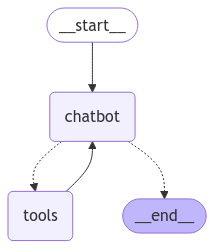

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: [{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'San Paulo', 'region': 'Sao Paulo', 'country': 'Brazil', 'lat': -23.5333, 'lon': -46.6167, 'tz_id': 'America/Sao_Paulo', 'localtime_epoch': 1740061277, 'localtime': '2025-02-20 11:21'}, 'current': {'last_updated_epoch': 1740060900, 'last_updated': '2025-02-20 11:15', 'temp_c': 30.4, 'temp_f': 86.7, 'is_day': 1, 'condition': {'text': 'Sunny', 'icon': '//cdn.weatherapi.com/weather/64x64/day/113.png', 'code': 1000}, 'wind_mph': 6.7, 'wind_kph': 10.8, 'wind_degree': 309, 'wind_dir': 'NW', 'pressure_mb': 1018.0, 'pressure_in': 30.06, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 55, 'cloud': 0, 'feelslike_c': 31.2, 'feelslike_f': 88.2, 'windchill_c': 31.7, 'windchill_f': 89.0, 'heatindex_c': 33.1, 'heatindex_f': 91.6, 'dewpoint_c': 17.9, 'dewpoint_f': 64.3, 'vis_km': 10.0, 'vis_miles': 6.0, 'uv': 12.7, 'gust_mph': 8.2, 'gust_kph': 13.2}}"}, {"url": "https://www.weatherandclimate.info/monitor/8

## Part 3: Adding Memory to the Chatbot

In [17]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [18]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI()
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [19]:
graph = graph_builder.compile(checkpointer=memory)

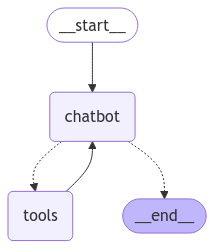

In [20]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [21]:
config = {"configurable": {"thread_id": "1"}}

In [22]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! How can I assist you today?


In [23]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name, Will! How can I help you today?


In [24]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I'm sorry, could you please remind me of your name?


In [25]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='c272c079-429b-4b8f-9fd5-cc7ca18bdfe2'), AIMessage(content='Hello Will! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 89, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-4e672515-2177-44cb-ae1c-159fe203806e-0', usage_metadata={'input_tokens': 89, 'output_tokens': 12, 'total_tokens': 101, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_me

In [26]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

## Part 4: Human-in-the-loop

In [3]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatOpenAI()
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [4]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

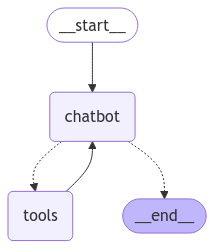

In [5]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [6]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_19FN6QNZ0a4bdlIGOaeNPnMM)
 Call ID: call_19FN6QNZ0a4bdlIGOaeNPnMM
  Args:
    query: I need expert guidance for building an AI agent. Can you provide assistance?


In [7]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [8]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

The experts recommend using LangGraph to build your AI agent. It's a reliable and extensible tool for creating advanced agents. Would you like more information or assistance with using LangGraph for your project?


## Part 5: Customizing State

In [11]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

In [12]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt


@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

In [13]:
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatOpenAI()
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [14]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_rHaFOibWrA5EZVJDoIuMVCMc)
 Call ID: call_rHaFOibWrA5EZVJDoIuMVCMc
  Args:
    query: LangGraph release date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://github.com/langchain-ai/langgraph/releases", "content": "Releases ¬∑ langchain-ai/langgraph ¬∑ GitHub Search code, repositories, users, issues, pull requests... Releases: langchain-ai/langgraph Releases ¬∑ langchain-ai/langgraph langgraph: release 0.2.70 (#3341) langgraph: add agent name to AI messages in create_react_agent (#3340) fix(langgraph): Dedupe input (right-side) messages in add_messages (#3338) Merge branch 'jacob/dedupe'

In [15]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: human_assistance

Command(update={'name': 'LangGraph', 'birthday': 'Jan 17, 2024', 'messages': [ToolMessage(content="Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}", tool_call_id='call_qsVez6bs1y8zqnz4PqJM4W0F')]})
================================== Ai Message ==================================

I found the release date for LangGraph, which was on January 17, 2024. I have submitted this information for review.


In [16]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{}

In [17]:
snapshot.values.keys()

dict_keys(['messages'])

In [18]:
graph.update_state(config, {"name": "LangGraph (library)"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff4485-4199-6fee-8006-2716cfcf2322'}}

In [19]:
graph.update_state(config, {"name": "LangGraph (library)"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff4487-dc73-665f-8007-4939aa9efcfc'}}

In [20]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph (library)'}

## Part 6: Time Travel

In [22]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI()
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [23]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_lttCdM3gtSlB5mIkxWmRtn96)
 Call ID: call_lttCdM3gtSlB5mIkxWmRtn96
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://github.com/langchain-ai/langgraph", "content": "GitHub - langchain-ai/langgraph: Build resilient language agents as graphs. LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Let's build a tool-calling ReAct-style agent that uses a search tool! The simplest way to create a tool-calling agent in LangGraph is to use create_react_agent: Define the tools for the agent to use Define the tools for the agent to use This m

In [24]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That sounds like an exciting project! Building an autonomous agent using LangGraph can be a fascinating endeavor. If you have any questions, need guidance, or assistance along the way, feel free to reach out. I'm here to help with any queries you may have during your autonomous agent development journey. Good luck with your project!


In [32]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 2:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


In [33]:
print(to_replay.next)
print(to_replay.config)

('tools',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1eff449c-54e8-6555-8001-a63588ef5217'}}


In [34]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_lttCdM3gtSlB5mIkxWmRtn96)
 Call ID: call_lttCdM3gtSlB5mIkxWmRtn96
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://github.com/langchain-ai/langgraph", "content": "GitHub - langchain-ai/langgraph: Build resilient language agents as graphs. LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Let's build a tool-calling ReAct-style agent that uses a search tool! The simplest way to create a tool-calling agent in LangGraph is to use create_react_agent: Define the tools for the agent to use Define the tools for the agent to use This means that after tools is called, agent node is called next. workflow.add_edge(\"tools\", 'agent') Normal edge: after the tools are invoked, the gra